### Segmentation 03

- Development for 3D segmentation

In [1]:
%run ../utils.py
import os
import os.path as osp
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cvutils import visualize
from cytokit import io as cytokit_io
from cytokit import config as cytokit_config
from skimage import feature
from skimage import filters
from skimage import measure
from skimage import segmentation
from skimage import morphology
from skimage import draw
from skimage import exposure
from scipy import ndimage

plt.gray()
init_session()

# exp_name = '20180611_D18_PMBC_500G'
# exp_conf_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], exp_name, 'config')
# exp_data_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], exp_name, 'output', 'nodeconv')
# nuc_cyc = 0
# nuc_ch = 0
# mem_cyc = 0
# mem_ch = 2
# #crop = [slice(0, 512), slice(0, 512)]
# crop = [slice(None, None), slice(None, None)]

exp_name = '7-7-17-multicycle'
exp_conf_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], '7-7-17-multicycle')
exp_data_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], '7-7-17-multicycle-out-none', '1-Processor')
nuc_cyc = 0
nuc_ch = 0
mem_cyc = 2
mem_ch = 1
crop = [slice(0, 512), slice(0, 512)]
# #crop = [slice(None, None), slice(None, None)]

model_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], 'modeling', 'cytopy', 'models', 'nuclei', 'v0.3')
model_path = osp.join(model_dir, 'nuclei_model.h5')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
exp_conf = cytokit_config.load(exp_conf_dir)

In [3]:
tile = cytokit_io.read_tile(osp.join(exp_data_dir, 'reg001_X01_Y01.tif'), exp_conf)
tile = tile[:, :, :, crop[0], crop[1]]
tile.shape, tile.dtype

((8, 9, 4, 512, 512), dtype('uint16'))

In [4]:
if tile.dtype == np.uint16:
    tile = exposure.rescale_intensity(tile, in_range=np.uint16, out_range=np.uint8).astype(np.uint8)

In [5]:
exp_conf.channel_names

['HOECHST1',
 'CollagenIV',
 'CD7',
 'Ki67',
 'HOECHST2',
 'CD38',
 'CD31',
 'CD4',
 'HOECHST3',
 'CD45',
 'CD90',
 'CD19',
 'HOECHST4',
 'CD15',
 'CD3',
 'CD104',
 'HOECHST5',
 'CD21',
 'CD34',
 'CD278',
 'HOECHST6',
 'HLADR',
 'CD22',
 'CD279',
 'HOECST7',
 'CD8',
 'CD40',
 'cytokeratin',
 'HOECHST8',
 'CD9',
 'Podoplanin',
 'CD11c']

In [208]:
def prepocess(img, thresh):
    img = img > thresh
    img = morphology.remove_small_holes(img, area_threshold=9)
    img = morphology.remove_small_objects(img, min_size=9)
    return img


def get_flat_ball(size):
    struct = morphology.ball(size)
    
    # Ball structs should always be of odd size and double given radius pluse one
    assert struct.shape[0] == size * 2 + 1
    assert struct.shape[0] % 2 == 1
    
    # Get middle index (i.e. position 2 (0-index 1) for struct of size 3)
    mid = ((struct.shape[0] + 1) // 2) - 1
    
    # Flatten the ball so there is no connectivity in the z-direction
    struct[(mid+1):] = 0
    struct[:(mid)] = 0
        
    return struct

def get_segmentation_mask(img_bin_nuci, img_bin_memb=None, dilation_factor=0):
    if img_bin_memb is None:
        if dilation_factor > 0:
            return morphology.dilation(img_bin_nuci, selem=get_flat_ball(dilation_factor))
        else:
            return img_bin_nuci
    else:
        raise NotImplementedError()

In [209]:
img_nuc = tile[nuc_cyc, :, nuc_ch]
# plt.imshow(img_nuc)
# plt.gcf().set_size_inches(12, 12)
img_nuc.shape, img_nuc.dtype

((9, 512, 512), dtype('uint8'))

In [8]:
from cytokit.segmentation.models import unet_v1

input_shape = img_nuc.shape[1:] + (1,)
#conv_activation = lambda l: keras.layers.LeakyReLU(alpha=.3)(l)
conv_activation = lambda l: keras.layers.Activation('elu')(l)
model = unet_v1.get_model(3, input_shape, 'sigmoid', conv_activation=conv_activation)
model.load_weights(model_path)

In [210]:
(np.expand_dims(img_nuc, -1) / 255.).shape

(9, 512, 512, 1)

In [211]:
def get_zline(size):
    n = size * 2 + 1
    struct = np.zeros((n,)*3, dtype=np.uint8)
    struct[:,size,size] = 1
    return struct

In [72]:
img_pred = model.predict(np.expand_dims(img_nuc.astype(np.float32), -1) / 255.)
img_pred.shape

(9, 512, 512, 3)

In [270]:
img_bin_nuci = prepocess(img_pred[..., 0], .5)
img_bin_nucb = prepocess(img_pred[..., 1], .5)
img_bin_nucm = prepocess(img_pred[..., 2], .5)

In [271]:
# Use z-max kernel to stretch boundary into z-dimension

# img_bin_nucb_max = np.stack([
#     morphology.dilation(morphology.skeletonize(img_bin_nucb[i]))
#     for i in range(img_nuc.shape[0])
# ], 0)
# img_bin_nucb_max = morphology.dilation(img_bin_nucb_max, get_zline(4))

In [272]:
# Visualize stretched boundary

# visualize.display_images([img_bin_nucb[i] for i in range(img_nuc.shape[0])], size=15, cols=2, cmap='viridis')
# visualize.display_images([img_bin_nucb_max[i] for i in range(img_nuc.shape[0])], size=15, cols=2, cmap='viridis')

In [286]:
# Skeletonizing visualizations
#img_tmp = morphology.skeletonize_3d(img_bin_nucb)
#img_tmp = np.stack([morphology.skeletonize(img_bin_nucb[i]) for i in range(img_nuc.shape[0])], 0)
#visualize.display_images([img_bin_nucb_max[i] for i in range(img_nuc.shape[0])], size=15, cols=2, cmap='viridis')
#visualize.display_images([img_tmp[4]], size=30, cols=2, cmap='viridis')

In [274]:
# img_bin_nucm = img_bin_nucm & img_bin_nuci & ~img_bin_nucb_max
img_bin_nucm = img_bin_nucm & img_bin_nuci & ~img_bin_nucb

In [275]:
img_bin_nucm_label = morphology.label(img_bin_nucm)
img_bin_nuci_basin = ndimage.distance_transform_edt(img_bin_nuci)
img_bin_nucb_basin = ndimage.distance_transform_edt(img_bin_nucb)
img_basin = -img_bin_nuci_basin + img_bin_nucb_basin

In [276]:
img_bin = np.stack([img_bin_nuci, img_bin_nucb, img_bin_nucm], axis=-1)
img_bin.shape

(9, 512, 512, 3)

In [277]:
seg_mask = get_segmentation_mask(img_bin_nuci, dilation_factor=8)

In [278]:
img_seg = segmentation.watershed(img_basin, img_bin_nucm_label, mask=seg_mask)

In [279]:
img_seg_props = measure.regionprops(img_seg)
pd.Series([img_seg_props[i].filled_image.shape[0] for i in range(len(img_seg_props))]).value_counts()

8    347
7    218
9    214
2    102
3     85
6     70
1     67
4     55
5     51
dtype: int64

In [280]:
# struct = get_flat_ball(5)
# visualize.display_images([struct[i] for i in range(struct.shape[0])])

In [281]:
# crop = [slice(0, 512), slice(0, 512)]
# visualize.display_images([
#     img_pred[i, ..., 1][crop]
#     for i in range(img_nuc_border.shape[0])
# ], size=30, cols=2, cmap='viridis')

In [282]:
#img_border = segmentation.find_boundaries(img_seg, mode='inner', background=img_seg.min())

img_border = np.stack([
    segmentation.find_boundaries(img_seg[i], mode='inner', background=img_seg.min())
    for i in range(img_nuc.shape[0])
], axis=0)
img_border.shape

(9, 512, 512)

In [283]:
img_nuc_border = img_nuc.copy()
img_nuc_border = exposure.rescale_intensity(img_nuc_border, out_range=(128, 255)).astype(np.uint8)
img_nuc_border[img_bin[..., 2] > 0] = 90
#img_nuc_border[img_bin[..., 1] > 0] = 90
img_nuc_border[img_border > 0] = 0
img_nuc_border.dtype

dtype('uint8')

In [284]:
# plt.imshow(img_seg[1][:100,250:], cmap='Spectral')
# plt.gcf().set_size_inches(12, 12)

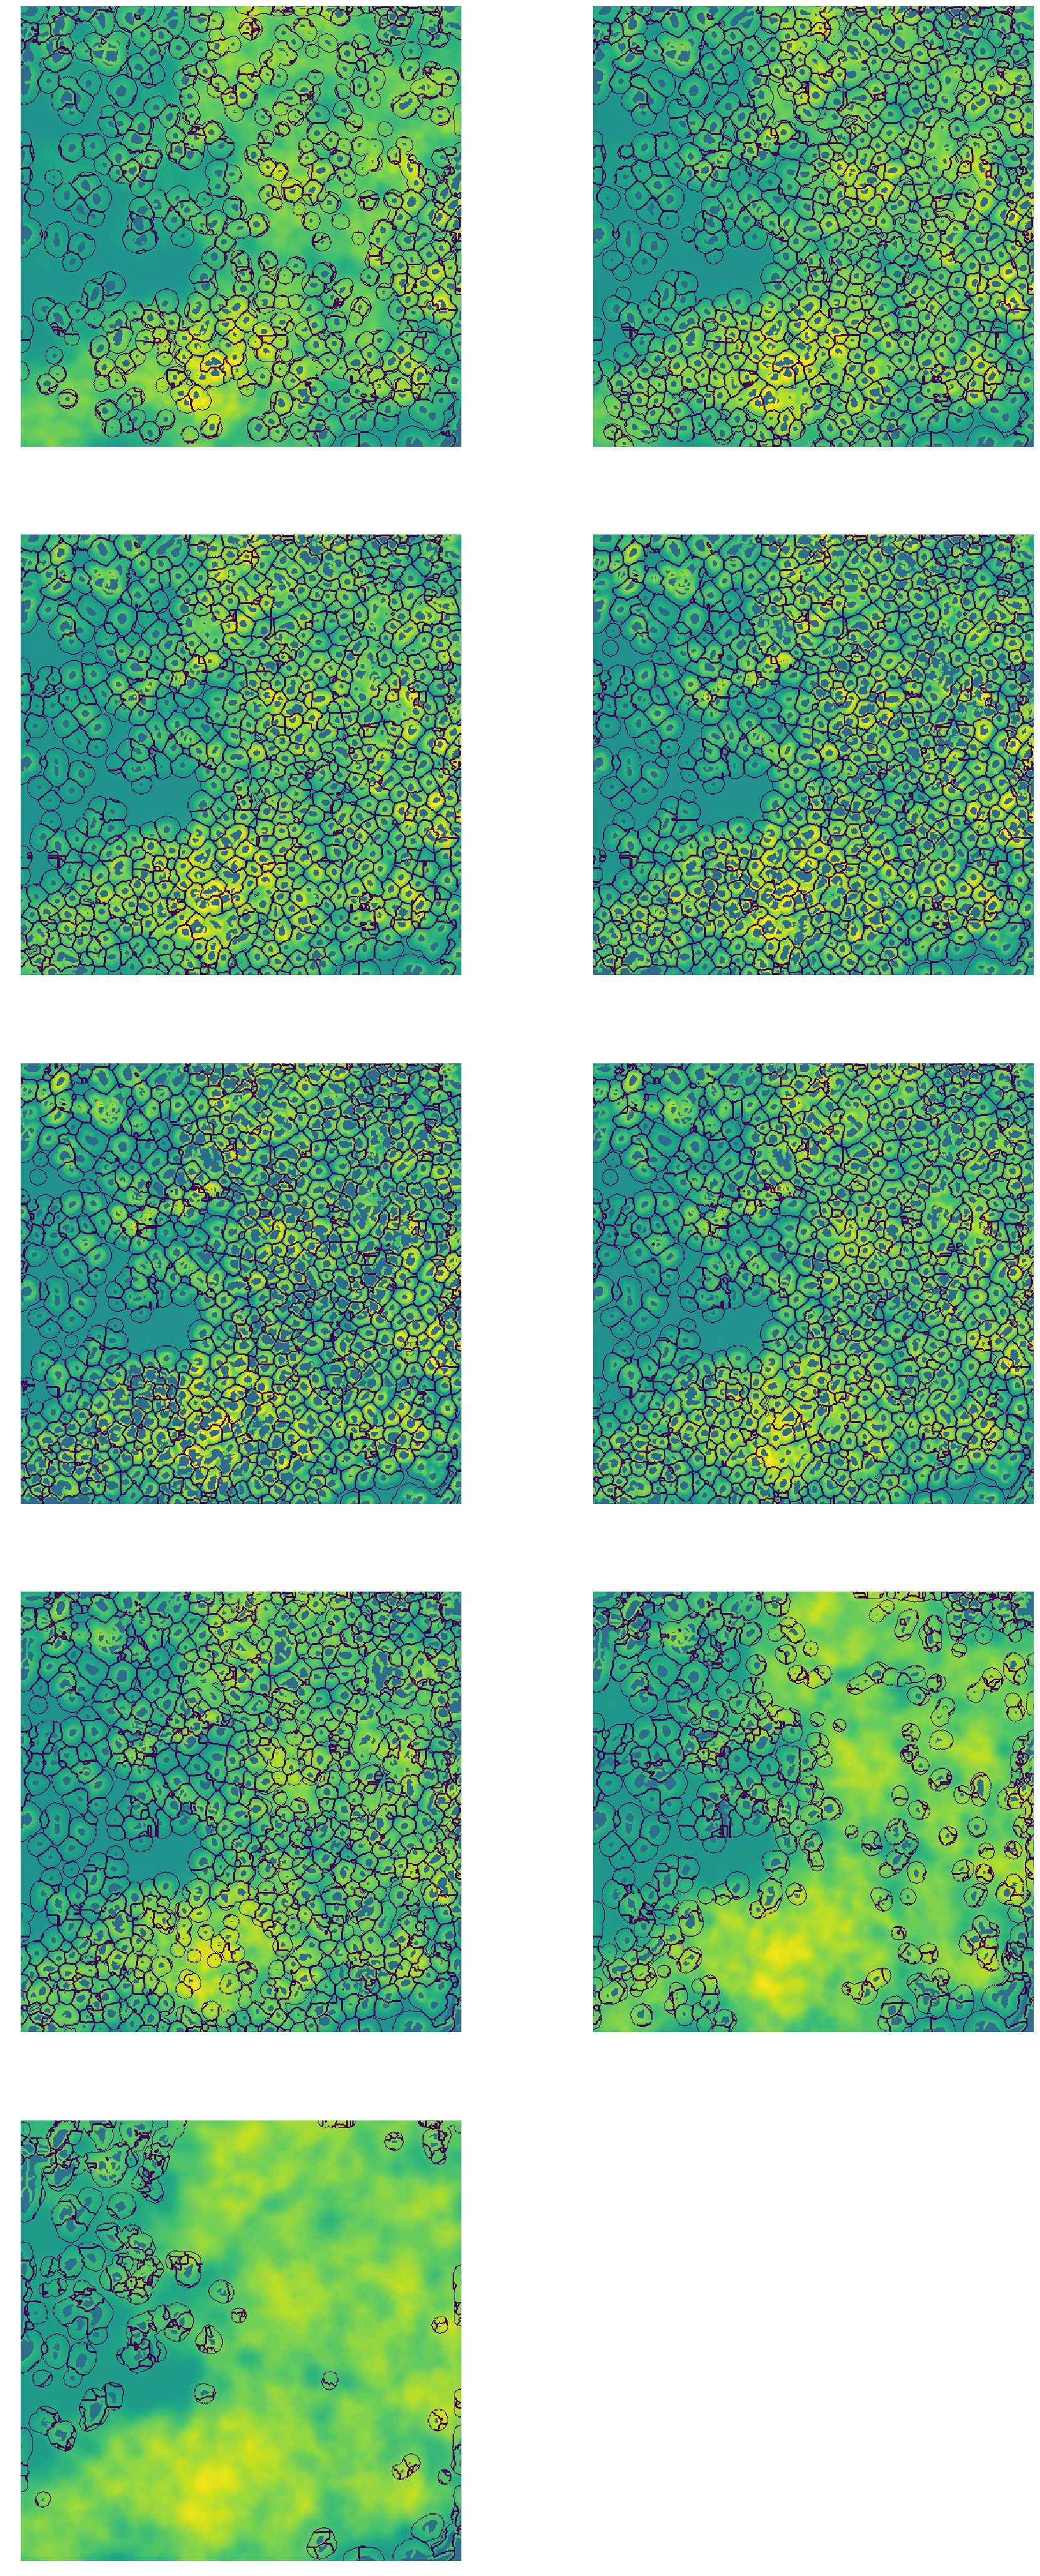

In [285]:
crop = [slice(0, 512), slice(0, 512)]
visualize.display_images([
    img_nuc_border[i][crop]
    #img_pred[i][crop].astype(float) 
    for i in range(img_nuc_border.shape[0])
], size=30, cols=2, cmap='viridis')